In [21]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import time
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [152]:
filename = "finalData"

def load_data(name):
    name = filename + "/" + name + ".npy"
    data = np.load(name)
    return data

test_dataset1 = load_data('test_dataset')
test_labels = load_data('test_labels')
valid_dataset = load_data('valid_dataset')
valid_labels = load_data('valid_labels')
train_dataset = load_data('train_dataset')
train_labels = load_data('train_labels')

print 'Training set:', train_dataset.shape, train_labels.shape
print 'Test set:', test_dataset1.shape, test_labels.shape
print 'Validation set:', valid_dataset.shape, valid_labels.shape

Training set: (163656, 64, 64) (163656, 6)
Test set: (6000, 64, 64) (6000, 6)
Validation set: (6000, 64, 64) (6000, 6)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [153]:
image_size = 64
num_channels = 1

def reformat(dataset):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    #labels = (np.arange(num_labels) == labels[:,:,None]).astype(np.float32)
    return dataset

train_dataset = reformat(train_dataset)
test_dataset = reformat(test_dataset1)
valid_dataset = reformat(valid_dataset)

print 'Training set:', train_dataset.shape
print 'Test set:', test_dataset.shape
print 'Validation set:', valid_dataset.shape


Training set: (163656, 64, 64, 1)
Test set: (6000, 64, 64, 1)
Validation set: (6000, 64, 64, 1)


In [71]:
def accuracy(predictions, labels):
    preds = np.argmax(predictions, 2)
    correct = []
    for i in range(predictions.shape[0]):
        correct.append((preds[i]==labels[i]).all())
        #print preds[i], labels[i]
    score = 100.0 * np.sum(correct) / predictions.shape[0]
    return score

In [163]:
np.random.seed(42)

def print_imgs(predictions, labels, dataset):
    preds = np.argmax(predictions, 2)
    incorrect = []
    for i in range(predictions.shape[0]):
        if (preds[i]==labels[i]).all():
            None
        else:
            incorrect.append(i)
    np.random.shuffle(np.asarray(incorrect))
    pics = incorrect[:10]
    for j in pics:
        plt.imshow(dataset[j])
        plt.show()
        print '       Prediction:', preds[j]
        print '       Actual Label:', labels[j]

In [193]:
batch_size = 64
patch_size = 5
depth = 32
depth2 = 64
depth3 = 128
l_rate = 0.01
num_hidden = 2048
seq_length = 5
num_labels = 12
drop_out_keep_prob = 0.5

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, train_labels.shape[1]))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset) 
    
    # Variables.
    layer1_weights = tf.get_variable('l1', shape=[patch_size, patch_size, num_channels, depth],\
           initializer=tf.contrib.layers.xavier_initializer())
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.get_variable('l2', shape=[patch_size, patch_size, depth, depth2],\
           initializer=tf.contrib.layers.xavier_initializer())
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[depth2]))
    layer3_weights = tf.get_variable('l3', shape=[patch_size, patch_size, depth2, depth3],\
           initializer=tf.contrib.layers.xavier_initializer())
    layer3_biases = tf.Variable(tf.constant(0.1, shape=[depth3]))
    layer4_weights = tf.get_variable('l4', shape=[patch_size, patch_size, depth3, depth4],\
           initializer=tf.contrib.layers.xavier_initializer())
    layer4_biases = tf.Variable(tf.constant(0.1, shape=[depth4]))
    layer5_weights = tf.get_variable('l5', shape=[image_size // 16 * image_size // 16 * depth4, num_hidden],\
           initializer=tf.contrib.layers.xavier_initializer())
    layer5_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]))
    
    seqLength_weights = tf.get_variable('seq1', shape=[num_hidden, seq_length],\
           initializer=tf.contrib.layers.xavier_initializer())
    seqLength_biases = tf.Variable(tf.constant(0.1, shape=[seq_length]))
    digit1_weights = tf.get_variable('d1', shape=[num_hidden, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    digit1_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))
    digit2_weights = tf.get_variable('d2', shape=[num_hidden, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    digit2_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))
    digit3_weights = tf.get_variable('d3', shape=[num_hidden, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    digit3_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))
    digit4_weights = tf.get_variable('d4', shape=[num_hidden, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    digit4_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))
    digit5_weights = tf.get_variable('d5', shape=[num_hidden, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    digit5_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))
  

    # Model.
    def model(data, train=False):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        pool = tf.nn.max_pool(hidden, 
                             ksize=[1,2,2,1],
                             strides=[1,2,2,1],
                             padding='SAME')
        conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        pool = tf.nn.max_pool(hidden, 
                             ksize=[1,2,2,1],
                             strides=[1,2,2,1],
                             padding='SAME')
        conv = tf.nn.conv2d(pool, layer3_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer3_biases)
        pool = tf.nn.max_pool(hidden, 
                             ksize=[1,2,2,1],
                             strides=[1,2,2,1],
                             padding='SAME')
        conv = tf.nn.conv2d(pool, layer4_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer4_biases)
        pool = tf.nn.max_pool(hidden, 
                             ksize=[1,2,2,1],
                             strides=[1,2,2,1],
                             padding='SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer5_weights) + layer5_biases)
        if train:
            hidden = tf.nn.dropout(hidden, drop_out_keep_prob) 
        logits1 = tf.matmul(hidden, seqLength_weights) + seqLength_biases
        logits2 = tf.matmul(hidden, digit1_weights) + digit1_biases
        logits3 = tf.matmul(hidden, digit2_weights) + digit2_biases
        logits4 = tf.matmul(hidden, digit3_weights) + digit3_biases
        logits5 = tf.matmul(hidden, digit4_weights) + digit4_biases
        logits6 = tf.matmul(hidden, digit5_weights) + digit5_biases
        return logits1, logits2, logits3, logits4, logits5, logits6
  
    # Training computation.
    logits1, logits2, logits3, logits4, logits5, logits6 = model(tf_train_dataset, train=True)

    
    # loss function
    loss1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,0]))
    loss2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,1]))
    loss3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,2]))
    loss4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,3]))
    loss5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,4]))
    loss6 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits6, tf_train_labels[:,5]))
    
    loss = loss2 + loss3 + loss4 + loss5 + loss6
            
    # L2 regularization for the fully connected parameters.
    #regularizers = (tf.nn.l2_loss(layer3_weights) +
    #                  tf.nn.l2_loss(layer4_weights))
    # Add the regularization term to the loss.
    #loss += 0.001 * regularizers

    # Optimizer
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(l_rate, global_step, 15000, 0.95, staircase = True)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.pack([
                       tf.nn.softmax(logits2),\
                       tf.nn.softmax(logits3),\
                       tf.nn.softmax(logits4),\
                       tf.nn.softmax(logits5),\
                       tf.nn.softmax(logits6)], axis=1)

    valid_prediction = tf.pack([
                       tf.nn.softmax(model(tf_valid_dataset)[1]),\
                       tf.nn.softmax(model(tf_valid_dataset)[2]),\
                       tf.nn.softmax(model(tf_valid_dataset)[3]),\
                       tf.nn.softmax(model(tf_valid_dataset)[4]),\
                       tf.nn.softmax(model(tf_valid_dataset)[5])], axis=1)

    test_prediction = tf.pack([
                      tf.nn.softmax(model(tf_test_dataset)[1]),\
                      tf.nn.softmax(model(tf_test_dataset)[2]),\
                      tf.nn.softmax(model(tf_test_dataset)[3]),\
                      tf.nn.softmax(model(tf_test_dataset)[4]),\
                      tf.nn.softmax(model(tf_test_dataset)[5])], axis=1)


Initialized
Minibatch loss at step 0: 12.310450
Minibatch accuracy: 0.0%
Validation accuracy: 0.3%

Minibatch loss at step 1000: 2.680275
Minibatch accuracy: 46.9%
Validation accuracy: 51.0%

Minibatch loss at step 2000: 1.956940
Minibatch accuracy: 59.4%
Validation accuracy: 65.5%

Minibatch loss at step 3000: 1.885458
Minibatch accuracy: 62.5%
Validation accuracy: 71.7%

Minibatch loss at step 4000: 1.178895
Minibatch accuracy: 78.1%
Validation accuracy: 74.5%

Minibatch loss at step 5000: 1.704438
Minibatch accuracy: 62.5%
Validation accuracy: 76.2%

Minibatch loss at step 6000: 1.734466
Minibatch accuracy: 71.9%
Validation accuracy: 77.4%

Minibatch loss at step 7000: 1.065556
Minibatch accuracy: 81.2%
Validation accuracy: 77.7%

Minibatch loss at step 8000: 0.655027
Minibatch accuracy: 84.4%
Validation accuracy: 79.4%

Minibatch loss at step 9000: 1.302209
Minibatch accuracy: 70.3%
Validation accuracy: 79.6%

Minibatch loss at step 10000: 1.297309
Minibatch accuracy: 79.7%
Validat

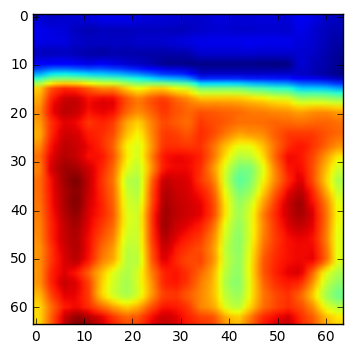

       Prediction: [ 1  1  9 11 11]
       Actual Label: [ 1  1  1 11 11]


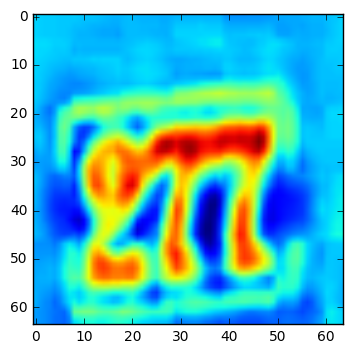

       Prediction: [ 2  7 11 11 11]
       Actual Label: [ 2  7  7 11 11]


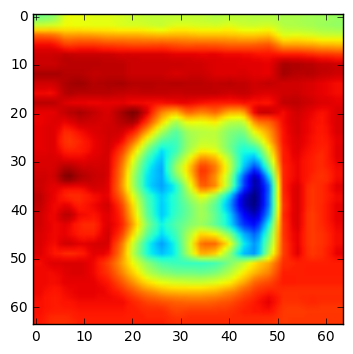

       Prediction: [ 8 11 11 11 11]
       Actual Label: [ 9 11 11 11 11]


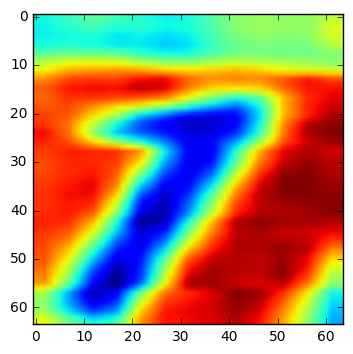

       Prediction: [ 7 11 11 11 11]
       Actual Label: [ 1 11 11 11 11]


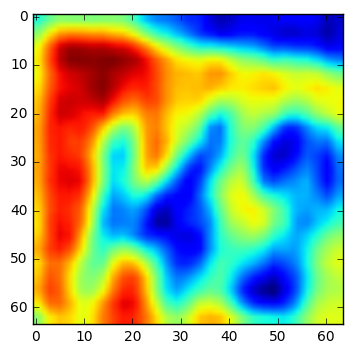

       Prediction: [ 4  4  2 11 11]
       Actual Label: [ 1  4  2 11 11]


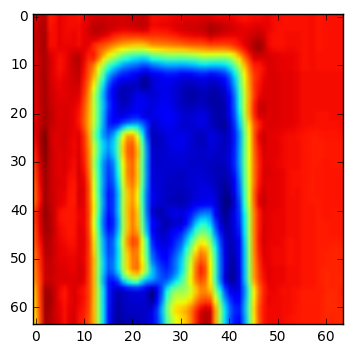

       Prediction: [ 1  7 11 11 11]
       Actual Label: [ 1  4 11 11 11]


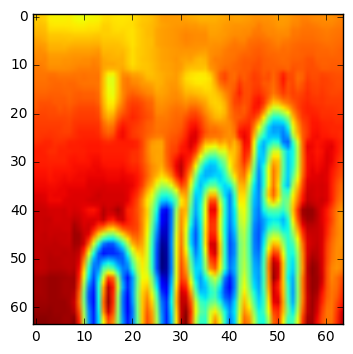

       Prediction: [ 2  0  6  6 11]
       Actual Label: [ 2  1  9  6 11]


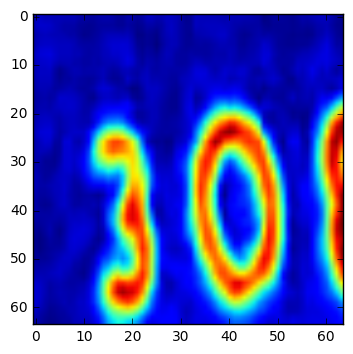

       Prediction: [ 3  0  1 11 11]
       Actual Label: [ 3  0  8 11 11]


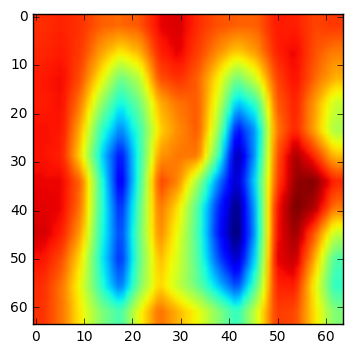

       Prediction: [ 1  4  3 11 11]
       Actual Label: [ 1  1  2 11 11]


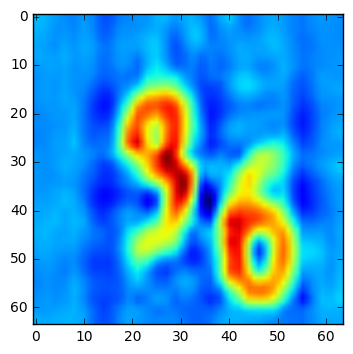

       Prediction: [ 9  6 11 11 11]
       Actual Label: [ 3  6 11 11 11]

Elapsed time: 769.884995937


In [194]:
num_steps = 30001

step_num = []
train_loss = []
train_acc = []
valid_acc = []

with tf.Session(graph=graph) as session:
    starttime = time.time()
    tf.initialize_all_variables().run()
    print 'Initialized'
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 1000 == 0):
            t_acc = accuracy(predictions, batch_labels[:,1:6])
            v_acc = accuracy(valid_prediction.eval(), valid_labels[:,1:6])
            test_acc = accuracy(test_prediction.eval(), test_labels[:,1:6])
            
            step_num.append(step)
            train_loss.append(l)
            train_acc.append(t_acc)
            valid_acc.append(v_acc)
            
            print 'Minibatch loss at step %d: %f' % (step, l)
            print 'Minibatch accuracy: %.1f%%' % t_acc
            print 'Validation accuracy: %.1f%%\n' % v_acc
    print 'Test accuracy: %.1f%%' % test_acc
    print_imgs(test_prediction.eval(), test_labels[:,1:6], test_dataset1)
print '\nElapsed time:', time.time() - starttime


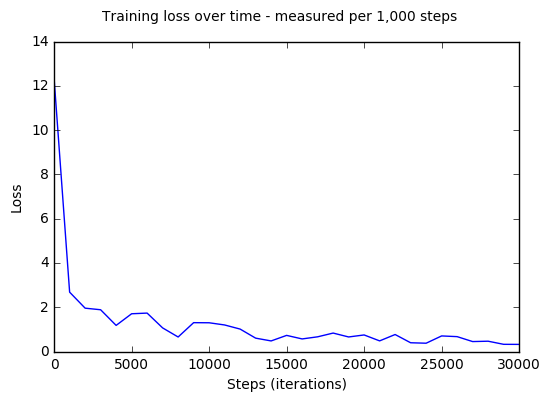

In [196]:
plt.suptitle('Training loss over time - measured per 1,000 steps')
plt.xlabel('Steps (iterations)')
plt.ylabel('Loss')
plt.plot(step_num, train_loss)
plt.show()

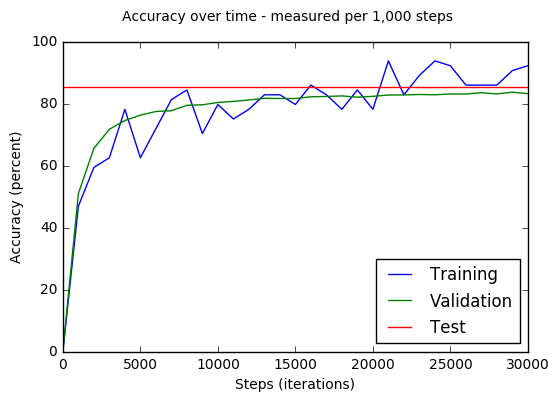

In [197]:
plt.suptitle('Accuracy over time - measured per 1,000 steps')
plt.xlabel('Steps (iterations)')
plt.ylabel('Accuracy (percent)')
plt.plot(step_num, train_acc)
plt.plot(step_num, valid_acc)
plt.axhline(y=test_acc, color='r')
plt.legend(['Training', 'Validation', 'Test'], loc='lower right')
plt.show()

In [198]:
params = {'steps':num_steps, 'batch_size':batch_size, 'depth1':depth, 
          'depth2':depth2, 'depth3':depth3, 'depth4':depth4, 'fully_connected':num_hidden, 
          'learning_rate':l_rate, 'dropout_keep_prob':drop_out_keep_prob}
pData = pd.DataFrame(data=params, index = np.arange(1))
display(pData)

,batch_size,depth1,depth2,depth3,depth4,dropout_keep_prob,fully_connected,learning_rate,steps
0,64,32,64,128,160,0.5,2048,0.01,30001
